# Random Forests on Time Series
Household power consumption is a dataset that caught my eye. It has over a million readings of power consumed in an household, with different columns for active & reactive power, current, voltage etc. all sampled and averaged in one-minute intervals. I played around with the dataset a little, performed exploratory analysis etc. I decided to read up on any existing analysis of the dataset and I found a paper using ARMA/ARIMA on it. This paper introduced me to time series analysis used on electric power. 

I tried out fitting ARIMA model on the power dataset myself. I wondered how would conventional machine learning methods fare predicting the future values of the electric power and I tried it out.

## Data Wrangling

The data is well recorded. Proper separation and missing value characters have been used. We shall be using R primarily to perform the cleaning and analysis.

The following code was written to tidy the data into a better form –

In [2]:
require(lubridate)
require(zoo)
data = read.table("household_power_consumption.txt", sep=";", header=TRUE, na.strings="?")
head(data)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
17/12/2006,00:00:00,1.044,0.152,242.73,4.4,0,2,0
17/12/2006,00:01:00,1.520,0.220,242.20,7.4,0,1,0
17/12/2006,00:02:00,3.038,0.194,240.14,12.6,0,2,0
17/12/2006,00:03:00,2.974,0.194,239.97,12.4,0,1,0
17/12/2006,00:04:00,2.846,0.198,240.39,11.8,0,2,0
17/12/2006,00:05:00,2.848,0.198,240.59,11.8,0,1,0


In [3]:
colnames(data) = c("Date", "Time", "ActivePower", "ReactivePower", "Voltage", 
                  "Current", "Sub1", "Sub2", "Sub3")
data$DateTime = do.call(paste, c(data[c("Date", "Time")], sep = " ")) #Concatenating Date and Time columns
#Deleting redundant columns after concatenating
data$Date = NULL
data$Time = NULL
data = data[c(8,1:7)] #Rearranging the columns
data[,1] = dmy_hms(data[,1])
head(data)

DateTime,ActivePower,ReactivePower,Voltage,Current,Sub1,Sub2,Sub3
2006-12-17 00:00:00,1.044,0.152,242.73,4.4,0,2,0
2006-12-17 00:01:00,1.520,0.220,242.20,7.4,0,1,0
2006-12-17 00:02:00,3.038,0.194,240.14,12.6,0,2,0
2006-12-17 00:03:00,2.974,0.194,239.97,12.4,0,1,0
2006-12-17 00:04:00,2.846,0.198,240.39,11.8,0,2,0
2006-12-17 00:05:00,2.848,0.198,240.59,11.8,0,1,0


There is an issue of missing data. As it is less than 5% of the actual data, it can be ignored. But as we are dealing with time series, every point counts. The plan is to replace the missing value with the value of the day before with some noise.

In [4]:
#First we need to see whether the number of missing data is same for all columns
sapply(data, function(x) sum(is.na(x)))

DateTime   ActivePower ReactivePower       Voltage       Current 
            0         25979         25979         25979         25979 
         Sub1          Sub2          Sub3 
        25979         25979         25979

In [5]:
for(j in 2:8) {
 for(i in which(is.na(data[,j]))){
    data[i, j] = abs(jitter(data[i-1440, j]))
    }
}
length(which(is.na(data)))

[1] 0

Now hourly-averaged and daily-averaged dataframes are created. The DateTime column isn't going to be used in the machine learning algorithms as it is not very clear how these algorithms handle POSIXct data. The effect of date and time shall be represented by dummy variables -
- dow – The day of the week. 
- month – Self-explanatory.
- dom  – The day of the month. 
- hour – Only in the hourly data frame. 

In [6]:
hourly = aggregate(data,format(data["DateTime"],"%Y-%m-%d %H:00"),mean, na.rm=TRUE)
#deleting first column
hourly[[1]] = NULL

In [7]:
hourly$dow = wday(hourly$DateTime)
hourly$month = month(hourly$DateTime)
hourly$dom = mday(hourly$DateTime)
hourly$hour = hour(hourly$DateTime)
head(hourly)

DateTime,ActivePower,ReactivePower,Voltage,Current,Sub1,Sub2,Sub3,dow,month,dom,hour
2006-12-16 19:29:30,1.882467,0.10243333,240.9618,8.126667,0,0.4666667,0.000000,7,12,16,19
2006-12-16 20:29:30,3.349400,0.13693333,240.4483,14.246667,0,25.2333333,0.000000,7,12,16,20
2006-12-16 21:29:30,1.587267,0.07823333,245.8187,6.870000,0,0.5666667,0.000000,7,12,16,21
2006-12-16 22:29:30,1.662200,0.07953333,244.5135,7.206667,0,0.7666667,0.000000,7,12,16,22
2006-12-16 23:29:30,2.215767,0.09346667,243.8555,9.333333,0,0.5666667,8.883333,7,12,16,23
2006-12-17 00:29:30,1.996733,0.06023333,243.7102,8.566667,0,0.1666667,4.650000,1,12,17,0


In [34]:
#splitting the data into training and testing sets
train = hourly[1:floor(0.7*nrow(hourly)),]
test = hourly[ceiling(0.7*nrow(hourly)):nrow(hourly),]

## Time Series Analysis
The training data is used for fitting the model. We shall use an ARIMA model. An ARIMA model is a generalized version of ARMA. In this model, both the output variable and the error term are linearly dependent on previous values (as indicated by the presence of lag operator).

$ \left( 1 - \sum_{i=1}^p \phi_i L^i \right)
(1-L)^d X_t
= \left( 1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t \,$


As we are trying to predict active power, we create a time series from the ActivePower column from the training set. We shall decompose these series to observe trends and seasonality

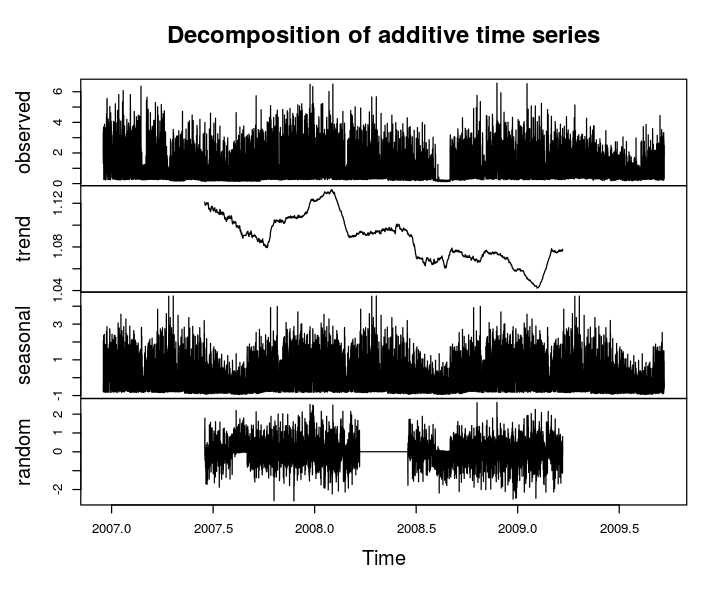

In [59]:
options(repr.plot.width=6, repr.plot.height=5)
hourly_time_series = ts(train[[2]], start=c(2006,8400), frequency=24*365)
#The start parameter is set to be 2006, 8400 because the first reading
#in the data is the 8400th hour of the year
plot(decompose(hourly_time_series))

We use `auto.arima()` function in the forecast package to determine the order of the ARIMA model to be fitted. Then we fit the model and predict the values for the next 10375 points (as the length of the htest data frame is 10375)



In [37]:
require(forecast)
auto.arima(hourly_time_series, stepwise=FALSE, approximation=FALSE)

Series: hourly_time_series 
ARIMA(2,1,2)                    

Coefficients:
         ar1      ar2      ma1     ma2
      1.3697  -0.5335  -1.6166  0.6208
s.e.  0.0200   0.0132   0.0212  0.0211

sigma^2 estimated as 0.3988:  log likelihood=-23219.72
AIC=46449.44   AICc=46449.44   BIC=46489.91

In [45]:
fit = arima(hourly_time_series, order = c(2,1,2))
arima_pred = predict(fit, n.ahead=10375)
sqrt(mean((arima_pred$pred - test[[2]])^2))

[1] 0.8151632

RMSE comes out to be around $0.815$

## Conventional machine learning algorithms

### Regression model

In [50]:
require(rpart)
hourly_regmodel = rpart(formula=ActivePower~.,data=train,method="anova")
hourly_regmodel_pred = predict(hourly_regmodel,test)
sqrt(mean((hourly_regmodel_pred-test[[2]])^2))

[1] 0.1635818

### Random Forest

[1] 0.04699293

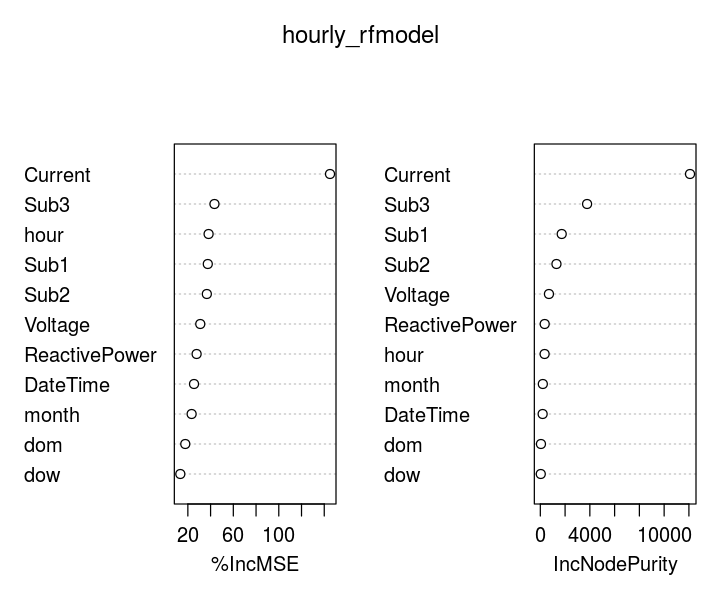

In [60]:
require(randomForest)
hourly_rfmodel = randomForest(formula=ActivePower~., data=train, ntree=1000, importance=TRUE)
hourly_rfmodel_pred = predict(hourly_rfmodel, test)
sqrt(mean((hourly_rfmodel_pred - orig)^2))
varImpPlot(hourly_rfmodel)

We get RMSE's of $0.16$ and $0.04$ for the regression model and random forest respectively. This is incredibly lower than the one we got from ARIMA prediction.

So what is actually going on? On a closer look, the predictors for the ML algorithms have been chosen wrongly. In a practical setting, it is impossible to have physical measurements like **Current, Sub1, Voltage** etc. beforehand. So let’s try running RandomForest with only the dow, dom, month and hour variables to predict Active Power and see how our RMSE is affected.



In [67]:
hourly_rfmodel_mod = randomForest(formula=ActivePower~hour+month+dow+dom,
                                 data=train, ntree=1000, importance=TRUE)

hourly_rfmodel_mod_pred = predict(hourly_rfmodel_mod, test)
sqrt(mean((hourly_rfmodel_mod_pred-test[[2]])^2))

[1] 0.6553794

We notice a drastic change in the RMSE, increasing by a magnitude of 16 for hourly series. But the new RMSE for Random Forests still remains less than those calculated for ARIMA. 

## References

1. [Individual household electric power consumption Data Set”](http://archive.ics.uci.edu/ml) UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science

2. “Time Series Analysis of Household Electric Consumption with ARIMA and ARMA Models” – Pasapitch Chujai, Nittaya Kerdprasop, and Kittisak Kerdprasop

3. [Why and how to use random forest variable importance measures (and how you shouldn’t)](http://www.statistik.uni-dortmund.de/useR-2008/slides/Strobl+Zeileis.pdf)

4. [Using R for Time Series Analysis](http://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/src/timeseries.html)